In [1]:
import numpy as np
from pandas import read_csv
import pandas_datareader.data as web

In [2]:
doge = web.DataReader('MONA-USD', 'yahoo')
doge

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-11-09,3.039360,2.840420,2.855220,2.967630,4630550,2.967630
2017-11-10,2.993850,2.606440,2.959770,2.616590,3069090,2.616590
2017-11-11,2.714720,2.520320,2.627440,2.597220,3258960,2.597220
2017-11-12,3.109670,2.173080,2.598040,2.817210,9822060,2.817210
2017-11-13,3.254420,2.666150,2.795100,2.895720,9818930,2.895720
...,...,...,...,...,...,...
2022-04-27,0.874509,0.846216,0.854779,0.853320,290011,0.853320
2022-04-28,0.861507,0.836389,0.852525,0.843836,211458,0.843836
2022-04-29,0.851174,0.818889,0.843720,0.824758,153179,0.824758


In [3]:
#lstm_data = np.genfromtxt('./sample_data/lstm.csv', delimiter=',', skip_header=True)
lstm_data = read_csv('lstmmona.csv')
lstm_data = lstm_data.drop(['Date'], axis=1)
print(lstm_data)

        High       Low      Open     Close   Volume  Adj Close  Polarity Score
0   1.241455  1.182781  1.236694  1.184539  1251855   1.184539        0.095867
1   1.054188  1.000561  1.016678  1.008785   467346   1.008785        0.146020
2   1.022445  0.989817  1.014940  0.996675   304333   0.996675        0.138143
3   0.978820  0.965322  0.970673  0.972663   205397   0.972663        0.146417
4   1.197341  1.177413  1.184803  1.184319   696471   1.184319        0.071015
..       ...       ...       ...       ...      ...        ...             ...
57  1.020251  0.994093  1.002975  0.999426   565050   0.999426        0.114973
58  0.851174  0.818889  0.843720  0.824758   153179   0.824758        0.131016
59  1.002289  0.977300  0.999467  0.985450   564840   0.985450        0.107061
60  0.833132  0.803969  0.825560  0.804979   208142   0.804979        0.141040
61  1.010521  0.969276  0.985485  0.979062   585842   0.979062        0.083907

[62 rows x 7 columns]


In [4]:
lstm_data_X = lstm_data.drop(['Close'], axis=1)
lstm_data_y = lstm_data['Close']

In [5]:
look_back = 5 # how many days to look back
batch_size = 3 # size of batches used when training
n_feat = 6 # number of features 
n_target = 2
n_validation = 6
n_test = 8
n_train = lstm_data_X.shape[0] - n_validation - n_test - 1


In [6]:
n_train

47

In [7]:
#lstm_data_X_train = lstm_data_X.iloc[:30,:]
#lstm_data_X_val = lstm_data_X.iloc[30:40,:]
#lstm_data_X_test = lstm_data_X.iloc[40:52,:]

#lstm_data_y_train = lstm_data_y.iloc[:30]
#lstm_data_y_val = lstm_data_y.iloc[30:40]
#lstm_data_y_test = lstm_data_y.iloc[40:52]
# Convert to numpy arrays
#X_train = lstm_data_X_train.to_numpy()
#X_val = lstm_data_X_val.to_numpy()
#X_test = lstm_data_X_test.to_numpy()
#y_train = lstm_data_y_train.to_numpy()
#y_val = lstm_data_y_val.to_numpy()
#y_test = lstm_data_y_test.to_numpy()

In [8]:
lstm_data_X_train = lstm_data_X.iloc[:n_train,:]
lstm_data_X_val = lstm_data_X.iloc[n_train:n_train + n_validation,:]
lstm_data_X_test = lstm_data_X.iloc[n_train + n_validation:n_train + n_validation + n_test,:]

lstm_data_y_train = lstm_data_y.iloc[:n_train]
lstm_data_y_val = lstm_data_y.iloc[n_train:n_train + n_validation]
lstm_data_y_test = lstm_data_y.iloc[n_train + n_validation:n_train + n_validation + n_test]
# Convert to numpy arrays
X_train = lstm_data_X_train.to_numpy()
X_val = lstm_data_X_val.to_numpy()
X_test = lstm_data_X_test.to_numpy()
y_train = lstm_data_y_train.to_numpy()
y_val = lstm_data_y_val.to_numpy()
y_test = lstm_data_y_test.to_numpy()

In [9]:
X_test

array([[8.74508977e-01, 8.46216023e-01, 8.54779005e-01, 2.90011000e+05,
        8.53320003e-01, 1.48283467e-01],
       [1.01842594e+00, 9.71315980e-01, 9.74134028e-01, 3.71633000e+05,
        1.01481199e+00, 1.31502325e-01],
       [1.03011203e+00, 9.99375999e-01, 1.00855601e+00, 7.81560000e+05,
        1.00295198e+00, 1.53586280e-01],
       [8.61506999e-01, 8.36389005e-01, 8.52524996e-01, 2.11458000e+05,
        8.43836010e-01, 1.28670540e-01],
       [1.02025104e+00, 9.94093001e-01, 1.00297499e+00, 5.65050000e+05,
        9.99426007e-01, 1.14973180e-01],
       [8.51173997e-01, 8.18889022e-01, 8.43720019e-01, 1.53179000e+05,
        8.24757993e-01, 1.31015680e-01],
       [1.00228906e+00, 9.77299988e-01, 9.99467015e-01, 5.64840000e+05,
        9.85450029e-01, 1.07060620e-01],
       [8.33132029e-01, 8.03969026e-01, 8.25559974e-01, 2.08142000e+05,
        8.04979026e-01, 1.41039940e-01]])

In [10]:
y_test

array([0.85332   , 1.01481199, 1.00295198, 0.84383601, 0.99942601,
       0.82475799, 0.98545003, 0.80497903])

In [11]:
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [12]:
train_data_gen = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(X_val, y_val, length=look_back, batch_size=batch_size)
test_data_gen = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)

In [13]:
# check generator dimensions
for i in range(len(train_data_gen)):
    x, y = train_data_gen[i]
    print(x.shape, y.shape)

(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)


In [14]:
model_lstm = Sequential()
model_lstm.add(LSTM(32, input_shape=(look_back, n_feat), return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             4992      
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 13,345
Trainable params: 13,345
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
hist = model_lstm.fit_generator(train_data_gen,
                                        steps_per_epoch=10,
                                        epochs=20,
                                        verbose=1,
                                        validation_data=val_data_gen)

Epoch 1/20


C:\Users\moham\AppData\Local\Temp/ipykernel_7864/192094070.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_lstm.fit_generator(train_data_gen,


10/10 [==============================] - 4s 90ms/step - loss: 0.3629 - mse: 0.3629 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 2/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0441 - mse: 0.0441 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 3/20
10/10 [==============================] - 0s 11ms/step - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 4/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 5/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 6/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0191 - mse: 0.0191 - val_loss: 1.3659e-04 - val_mse: 1.3659e-04
Epoch 7/20
10/10 [==============================] - 0s 11ms/step - loss: 0.0202 - mse: 0.0202 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 8/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0219 - mse:

In [16]:
pred = model_lstm.predict(test_data_gen)

In [17]:
test_data_gen[0]

(array([[[8.74508977e-01, 8.46216023e-01, 8.54779005e-01, 2.90011000e+05,
          8.53320003e-01, 1.48283467e-01],
         [1.01842594e+00, 9.71315980e-01, 9.74134028e-01, 3.71633000e+05,
          1.01481199e+00, 1.31502325e-01],
         [1.03011203e+00, 9.99375999e-01, 1.00855601e+00, 7.81560000e+05,
          1.00295198e+00, 1.53586280e-01],
         [8.61506999e-01, 8.36389005e-01, 8.52524996e-01, 2.11458000e+05,
          8.43836010e-01, 1.28670540e-01],
         [1.02025104e+00, 9.94093001e-01, 1.00297499e+00, 5.65050000e+05,
          9.99426007e-01, 1.14973180e-01]],
 
        [[1.01842594e+00, 9.71315980e-01, 9.74134028e-01, 3.71633000e+05,
          1.01481199e+00, 1.31502325e-01],
         [1.03011203e+00, 9.99375999e-01, 1.00855601e+00, 7.81560000e+05,
          1.00295198e+00, 1.53586280e-01],
         [8.61506999e-01, 8.36389005e-01, 8.52524996e-01, 2.11458000e+05,
          8.43836010e-01, 1.28670540e-01],
         [1.02025104e+00, 9.94093001e-01, 1.00297499e+00, 5.6

In [18]:
pred

array([[0.93805665],
       [0.93805665],
       [0.93805665]], dtype=float32)

In [19]:
import matplotlib.pyplot as plt

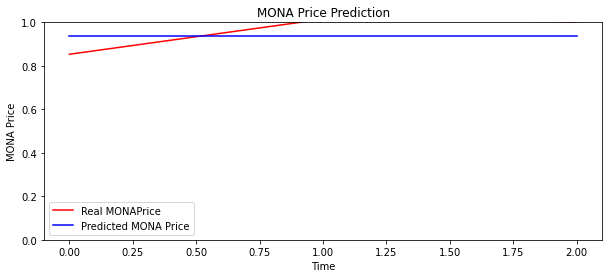

In [20]:
# Visualising the results
plt.figure(figsize=(10,4))
plt.plot(y_test[0:y_test.shape[0]-5], color = 'red', label = 'Real MONAPrice')
plt.plot(pred, color = 'blue', label = 'Predicted MONA Price')
plt.title('MONA Price Prediction')
plt.xlabel('Time')
plt.ylabel('MONA Price')
plt.ylim(0,1)
plt.legend()
plt.show()